<h2><font color="#004D7F" size=4>1. Text Mining</font></h2>



<h1><font color="#004D7F" size=5>Análisis de opinion (<i>sentiment analysis</i>) en textos</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Text Mining</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>
<br>

* [1. Introducción](#section1)
* [2. Recogida de datos](#section2)
* [3. Preparación de datos](#section3)
* [4. Representación de los datos mediante una matriz TF-IDF](#section4)
* [5. Aprendizaje de un modelo de regresión logística](#section5)
* [6. Validación del modelo](#section6)
* [7. Extracción de información del modelo](#section7)
* [8. Creación de un modelo simple](#section8)
* [9. Unificación de todos los pasos mediante un pipeline](#section9)

---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section1"></a>
## <font color="#004D7F"> 1. Introducción</font>
<br>


El _Procesamiento de Lenguaje Natural_ es un area de las ciencias de la computación cuyo objetivo es el diseño de programas capaces de procesar el lenguaje humano. Esta tarea es difícil ya que, en muchos casos, implica el análisis de texto a distintos niveles, y el uso de información de contexto. Sin embargo, para la resolución de algunos problemas de ciencia de datos, como por ejemplo la predicción o la clasificación, no es necesaria una comprensión total del lenguaje, y se pueden utilizar modelos más sencillos. En esta práctica, se construirá un modelo de clasificación a partir de 50000 comentarios sobre películas subidos a _Internet Movie Data Base_, y que están almacenados en archivos de texto. Este modelo ha de predecir con cierta tasa de acierto si un nuevo comentario es positivo o negativo.

Para poder entrenar un clasificador a partir de un conjunto de documentos de texto, es necesario representar estos datos en una matriz bidimensional. En el modelo _Bag of Words_, cada documento se representa a partir del conjunto de palabras que aparecen en él. Como paso previo a la construcción de la matriz de datos, se elabora un vocabulario con la unión de todos los términos que aparecen en algún documento. A partir de éste, se construye una matriz en la que cada fila representa un documento, y cada columna (cada característica) corresponde a un término. 

En la versión más básica, cada posición ${(d,t)}$ de la matriz contiene el valor para la medida ___Term Frequency___ (frecuencia de términos), que se denota $tf_{d,t}$, y refleja al número de veces que aparece el término $t$ en el documento $d$. Por ejemplo, dados estos tres documentos:

* Documento 1: "El objetivo de esta práctica es explicar el procesamiento básico de texto libre",
* Documento 2: "Uno de los enfoques utilizados es la bolsa de palabras",
* Documento 3: "Procesamiento de texto mediante bolsa de palabras",

la medida _Term Frequency_  generaría esta matriz de datos:

<br>
$$
X = \left[ \begin{array}{c | c | c | c | c | c | c }
El  & objetivo & de & esta & \cdots & bolsa & palabras \\
2 & 1 & 2 & 1 & \cdots & 0 & 0\\
0 & 0 & 2 & 0 & \cdots & 1 & 1\\
0 & 0 & 2 & 0 & \cdots & 1 & 1\\
\end{array}  \right] \begin{array}{c}
\\
Documento \, 1 \\
Documento \, 2 \\
Documento \, 3 \\
\end{array}
$$
<br>

En la matriz, $tf_{0,1}=2$, porque la palabra de índice $0$, "El", aparece dos veces en el documento $1$. 

Existen algunas variantes de esta medida, de modo que la matriz de datos se puede formar con:

* $tf_{d,t} \in \{0,1\}$ - Es decir, si el término aparece o no en el documento.
* $log(1+tf_{d,t})$ - Escala logarítmica.
* $tf_{d,t}/max_j \, tf_{d,t}$ - Escala en relación al término más frecuente en el documento.
<br>


La frecuencia de términos comunes como "el", "a", "de", etc, suele ser alta para la mayoría de los documentos. La métrica ___Inverse Document Frequency___ (frecuencia inversa en documentos) penaliza los términos en proporción a la frecuencia con que aparecen en el conjunto de documentos. La frequencia inversa de un término se formula como:

$$
idf_t = log\left(\frac{\# \,documentos}{\# \,documentos \, que \, incluyen \, la \, palabra \, t }\right)
$$

En el ejemplo anterior:

* $ idf_{el} = log\left(\frac{3}{1}\right) = 1.098 $
* $idf_{objetivo} = log\left(\frac{3}{1}\right) = 1.098$
* $idf_{de} = log\left(\frac{3}{3}\right) = 0$
* $idf_{esta} = log\left(\frac{3}{1}\right) = 1.098$
* $idf_{bolsa} = log\left(\frac{3}{2}\right) = 0.405$
* $idf_{palabras} = log\left(\frac{3}{2}\right) = 0.405$

<br>
Existen algunas formulaciones alternativas como:

$$
idf_t = log\left(\frac{1 + \# \,documentos}{1 + \# \,documentos \, que \, incluyen \, la \, palabra \, t }\right) + 1
$$

<br>
<br>

Por último, lo habitual es utilizar una combinación de estas métricas, denominada ___Term Frequency Inverse Document Frequency (tf-idf)___ , que se formula como:

$$
tf-idf_{d,t} = tf_{d,t} \times idf_t
$$
<br>

Dados los documentos anteriores, la matriz con los valores $tf-idf_{d,t}$ sería:

<br>

$$
X = \left[ \begin{array}{c | c | c | c | c | c | c }
El  & objetivo & de & esta & \cdots & bolsa & palabras \\
2.2 & 1.1 & 2.2 & 1.1 & \cdots & 0 & 0\\
0 & 0 & 2.2 & 0 & \cdots & 0.81 & 0.81\\
0 & 0 & 2.2 & 0 & \cdots & 0.81 & 0.81\\
\end{array}  \right] \begin{array}{c}
\\
Documento \, 1 \\
Documento \, 2 \\
Documento \, 3 \\
\end{array}
$$

<br>

Una vez se dispone de la representación de los datos en forma de matriz, y puesto que también se cuenta con el conjunto de valoraciones asociadas a cada revisión (aprendizaje supervisado), es posible construir un modelo de clasificación. Éste dependerá de la representación utilizada. Así, si se usa $tfidf_{d,t}$ se pueden utilizar métodos como la regresión logística o las máquinas de vectores de soporte. En el caso de utilizar la aparición o no de cada término en la posición $(d,t)$ de la matriz, se pueden utilizar también otros métodos como _Naive Bayes_.
<br>

Éste es el modelo más básico de análisis de opinión (_sentiment analysis_), pero existen modelos más complejos y refinados. Por otra parte, en muchos casos la diferencia en resultados no se debe solamente al clasificador elegido, sino del preprocesamiento que se haga sobre los textos, o a otros factores como el uso de _n-gramas_ o _POS tagging_. En este trabajo haremos un preprocesamiento sencillo, consistente en eliminar etiquetas HTML, caractéres no alfabéticos, y reducir las palabras a su raíz.

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a>
## <font color="#004D7F"> 2. Recogida de datos </font>
<br>

La carpeta `aclImdb` [(descarga)](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) contiene 50000 archivos de texto con comentarios sobre películas organizados en dos subcarpetas, denominadas `train` y `test`, que corresponden, respectivamente, los datos de entrenamiento y test. A su vez, cada una de estas carpetas, contiene una subcarpeta denominada `pos`, con las revisiones positivas, y otra denominada `neg`, con las negativas. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> La siguiente celda descarga y descomprime los datos (se han de tener instalados `curl` y `tar`).
</div>

In [2]:
#!curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar xzf aclImdb_v1.tar.gz

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Procesar los datos y almacenarlos en un formato adecuado para su posterior análisis. Para ello, se creará un objeto _DataFrame_ que guardará temporalmente las revisiones de la carpeta `train`, y que ha de tener dos columnas: la primera, denominada _review_, contendrá el texto con la revisión;  mientras que la segunda, denominada _sentiment_ contendrá la valoración de la revisión, que será $1$ (positiva) o $0$ (negativa). Una vez construído el _DataFrame_, se exportará a un archivo `.csv`, que se ha de denominar `datos_peliculas_train.csv`. Posteriormente, se procederá de manera similar para las revisiones que se encuentran en la carpeta `test`, que se guardarán en el archivo `datos_peliculas_test.csv`.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
El código tarda unos minutos, por lo que es conveniente utilizar una barra de progreso. Para ello es necesario instalar el paquete `progressbar2`, ya que `progressbar` no funciona con Python 3.x. Desde el código, no obstante, se importa `progressbar`. 
</div>

In [3]:
#!pip install progressbar2

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Si ya existen los _DataFrame_, no los construye. 
</div>

In [2]:
import time
import progressbar
import os

# Crea una barra de progreso
pBar = progressbar.ProgressBar(max_value=50000)

# En numpy y scikit-learn los datos se representan con valores
# numéricos, y hay que traducirlos.
sentiment_code ={'pos':1, 'neg':0}

# Recorre las carpetas correspondientes
step = 1
for dataset in ('train', 'test'):
    # Nombre del archivo que guardará los datos. 
    file_name = ''.join(['./datos_peliculas_',dataset,'.csv']);
    # Si ya existe, no lo construye.
    if os.path.isfile(file_name):
        continue
    df_tmp = pd.DataFrame()
    for sentiment in ('pos','neg'):
        # Abre la carpeta correspondiente
        path = './aclImdb/%s/%s' % (dataset, sentiment)
        # Para cada archivo
        for archivo in os.listdir(path):
            # Lo abre y extrae el texto
            with open(os.path.join(path, archivo), 'r') as datos:
                txt = datos.read()
            # Almacena la fila en el dataframe
            df_tmp = df_tmp.append([[txt, sentiment_code[sentiment]]], ignore_index=True)
            # Actualiza la barra de datos
            pBar.update(step)
            step+=1
            
    # Añade los nombres de las columnas
    df_tmp.columns = ['review', 'sentiment']
    #Escribe el dataframe en un archivo.
    df_tmp.to_csv(file_name, index=False)

Procesar miles de documentos requiere tiempo. Debido a esto, es conveniente utilizar un subconjunto durante la implementación y pruebas. La variable `num_docs`, definida a continuación, fija el tamaño de entrenamiento y test con el que trabajar. El máximo valor que puede tomar es 25000. No obstante, se recomienda comenzar con 5000 por motivos de agilidad, ya que, en caso de utilizar los conjuntos de datos completos, algunas operaciones básicas requieren varios minutos.

In [3]:
# Tamaño del subconjunto de documentos con el que se va a trabajar.
# Se tomarán num_docs para training/validadación y num_docs para test.
num_docs = 5000 


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Cargar los datos del archivo `./datos_peliculas_train.csv` en un _DataFrame_ denominado `df_reviews`. Seleccionar los `num_docs` primeros casos.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Es necesario ___desordenar los datos___, ya que están ordenados por clase y, bien al seleccionar un subconjunto para pruebas, o posteriormente al dividir el conjunto en entrenamiento/validación, todos los casos correspondientes a una partición podrían corresponder a la misma clase. 
</div>

---

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Recogida para train </font>
<br>

In [4]:
np.random.seed(0)

# Lee los datos
df_reviews = pd.read_csv('./datos_peliculas_train.csv')
 
# Desordena los elementos porque están ordenados por clases
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)
#df_reviews = df_reviews.reindex(np.random.permutation(df_reviews.index)).sort_index() # Da problemas. 

# Extrae el subconjunto con el que vamos a trabajar
df_reviews = df_reviews.iloc[:num_docs,:]

In [5]:
df_reviews.head()

,review,sentiment
0,My first opinions on this movie were of course...,0
1,"As incredible as it may seem, Gojoe is an anim...",1
2,Jean Claude Van Damme tries to rescue his care...,0
3,this short film trailer is basically about Sup...,1
4,I was living Rawlins when this movie was made ...,1


---

<a id="section22"></a>
## <font color="#004D7F"> 2.2. Recogida para test </font>
<br>

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Cargar los datos del archivo `./datos_peliculas_test.csv` en un _DataFrame_ denominado `df_new reviews`. Seleccionar los `num_docs` primeros casos. Al igual que anteriormente, se ha de desordenar el _DataFrame_.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Estos datos se utilizarán ___únicamente___ para evaluar el rendimiento del modelo final. 
</div>

In [6]:
# Lee los datos de test
df_new_reviews = pd.read_csv('./datos_peliculas_test.csv')

# Desordena los elementos porque están ordenados por clases.
df_new_reviews = df_new_reviews.sample(frac=1).reset_index(drop=True)
#df_new_reviews = df_new_reviews.reindex(np.random.permutation(df_new_reviews.index)).sort_index()

# Toma el subconjunto con el que trabajamos
df_new_reviews = df_new_reviews.iloc[:num_docs,:]

In [7]:
df_new_reviews.head()

,review,sentiment
0,Overrated mob comedy. Director Demme makes the...,0
1,Well in to 2002 I've got some catching up to d...,1
2,I have barely managed to view the entire film....,0
3,The theme is controversial and the depiction o...,1
4,This is one of those wonderful martial-arts mo...,0


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a>
# <font color="#004D7F"> 3. Preparación de los datos </font>
<br>

Una vez recogidos los datos, y almacenados en un formato adecuado, se procederá a la creación de un conjunto de entrenamiento de tipo _Bag of Words_ en el que cada revisión se representará mediante una lista de términos y su clase. En primer lugar han de limpiarse los datos, es decir, se han de eliminar las etiquetas HTML y los signos. Para ello, se han de crear sendas funciones. Después, se convertirá cada cadena de texto en una lista de términos relevantes.
<br>

---

<a id="section31"></a>
## <font color="#004D7F"> 3.1. Eliminación de etiquetas HTML</font>
<br>

En la mayoría de los casos, las etiquetas _HTML_ introducen información innecesaria en el modelo _Bag of Words_. Por ello, es conveniente eliminarlas. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font>  Implementar una función, denominada `removeHTML()`, que acepte como parámetro una cadena de texto, elimine de la misma las etiquetas _HTML_, y devuelva la nueva cadena.  Esta función ha de apoyarse en el manejo de expresiones regulares.

In [8]:
import re

def removeHTML(text):
    # Elmina las etiquetas HTML
    text = re.sub('<[^>]*>','', text)
    # Devuelve el texto
    return text

# Test
texto = 'Yo sigo el curso  <a href="http://www.ctic.uni.edu.pe/">Machine Learning</a> de la <a href="http://www.unie.edu.pe/">UNI</a>'
print(removeHTML(texto))
#Yo sigo el curso CiDAEN de la UCLM

Yo sigo el curso  Machine Learning de la UNI


---

<a id="section32"></a>
## <font color="#004D7F"> 3.2. Eliminación de caracteres no alfabéticos (excepto emoticonos)</font>
<br>

Los caracteres no alfabéticos tampoco son relevantes en el modelo de bolsa de palabras. Sin embargo, en este contexto sí que pueden serlo los emoticonos, yq que contienen información relevante con respecto a la valoración que se hace en los comentarios.


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Implementar una función, denominada `clean()`, que acepte como parámetro una cadena de texto y elimine de la misma los caracteres que no correspondan a palabras, con excepción de los emoticonos. Para ello: primero ha de detectar y guardar los emoticonos; después, ha de eliminar los caracteres no alfanuméricos; y por último, ha de añadir al resultado los emoticonos detectados en el primer paso.


Es necesario utilizar expresiones regulares para implementar esta función. Consideraremos que los emoticonos se componen de tres partes: ojos, que puede ser uno de estos tres caracteres { `:` `;` `=` }, boca  que puede ser uno de estos cuatro {   `)` `(` `D` `P` }, y opcionalmente nariz { `-` }.  Se trata de construir una expresión regular que encuentre una sucesión de esos tres elementos. 

In [9]:
import re

def clean(text):
    # Guarda los emoticonos
    emoticons = re.findall('(?::|;|=)(?:-?)(?:\)|\(|D|P)',text)
    # Elimina los caracteres que no son alfabéticos
    text = re.sub('[\W]+',' ',text.lower())
    text = re.sub('[\d]+','',text.lower())
    # Añade los emoticonos, pero eliminando '-'
    text = text + ' '.join(emoticons).replace('-','')
    # Devuelve el texto
    return text

texto = ' ... ¡Si llegué a la película a las 10:00 con mucha ilusión (más o menos)!  ...  pero me fui bastante cabreado :('
print(clean(texto))
#   si llegué a la película a las     con mucha ilusión más o menos pero me fui bastante cabreado :(

 si llegué a la película a las   con mucha ilusión más o menos pero me fui bastante cabreado :(


---

<a id="section33"></a>
## <font color="#004D7F"> 3.3. Elaboración de la lista de palabras relevantes</font>
<br>

El siguiente paso en el preprocesamiento de los textos consiste en elaborar las listas de palabras. Una opción consiste simplemente en dividir la cadena de texto con el método `split()` de la clase `String`. Sin embargo, es recomendable seguir algunos pasos adicionales. Por ejemplo, existen palabras denominadas _stopwords_ (preposiciones, etc.) que no proporcionan niguna información, por lo que es mejor eliminarlas.  Para la implementación de esta parte, se va a usar la librería [nltk (Natural Language Toolkit)](http://www.nltk.org/). 

In [10]:
#!pip install nltk

_nltk_ se apoya en algunos archivos de datos que han de ser descargados _solamente_ la primera vez que se usan. En concreto, se descargarán los archivos necesarios para hacer la división en palabras o "_tokens_", y las _stopwords_. En la siguiente celda de código se extrae la lista _stopwords_ en idioma inglés y se almacenan en la variable `stopwords_en`. 

In [12]:
import nltk
#nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('english')   # Extrae las stopwords en inglés

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manwest/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
stopwords_en[:5]

['i', 'me', 'my', 'myself', 'we']

Por otra parte, las cadenas de texto "_gusta_" y "_gustó_" son distintas, por lo que también se considerarían palabras distintas (características distintas). Esto podría repercutir en una degradación del rendimiento del modelo. Existen dos técnicas que permiten agrupar las palabras por familias. La primera de ellas, denominada [_stemming_](https://es.wikipedia.org/wiki/Stemming), consiste en reducir cada palabra a su raíz. En el caso del ejemplo, devolvería "_gust_" para ambas palabras. La segunda técnica, denominada [_lematización_](https://es.wikipedia.org/wiki/Lematizaci%C3%B3n) consiste en reemplazar cada palabra por su lema que, en el caso del ejemplo,  es "_gustar_". Para esta práctica utilizaremos la primera de las técnicas. En concreto, utilizaremos el objeto `PorterStemmer()` del paquete `nltk.stem.porter`, que también es creado en la siguiente celda.

In [14]:
from nltk.stem.porter import PorterStemmer

#nltk.download('punkt')            # Solo es necesario ejecutar estas líneas 
#nltk.download('stopwords')        # una vez para descargar los archivos.

stemmer = PorterStemmer()          # Crea el stemmer 

[nltk_data] Downloading package punkt to /home/manwest/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manwest/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Crear una función denominada `extractTerms()` que reciba como parámetro una cadena de caracteres, y que devuelva la lista de términos correspondiente, descartando _stop words_, y sustituyendo cada palabra por su raíz. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> La descomposición de cada cadena de caracteres en palabras puede hacerse mediante el método `split()` de la clase `String`. Sin embargo, es preferible utilizar la función `nltk.word_tokenize()`. 
</div>

In [15]:
def extractTerms(text):
    word_list = [word for word in nltk.word_tokenize(text) if word not in stopwords_en]    
    # Obtiene la raíz de las palabras
    word_list = [stemmer.stem(word) for word in word_list] # Comentar para no usar PorterStemmer
    return word_list

text = "The goal of this assignment isn't to explain complex free text processing"
print(extractTerms(text))
#['the', 'goal', 'assign', "n't", 'explain', 'complex', 'free', 'text', 'process']

['the', 'goal', 'assign', "n't", 'explain', 'complex', 'free', 'text', 'process']


<div class="alert alert-block alert-danger">

<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
La función `PorterStemmer.stem()` devuelve excepciones en algunos casos. Parece que utilizando solamente 5000 casos (`num_docs=5000`), no hay problema. Sin embargo, sí que lo hay con algún caso concreto que aparece después. Por tanto, se recomienda comentar la línea correspondiente si se utiliza un número mayor de ejemplos. Como consecuencia de esto, observaréis que el vocabulario crece bastante (más del doble).  
</div>

---

<a id="section34"></a>
## <font color="#004D7F"> 3.4. Preprocesamiento del conjunto de datos</font>
<br>

Una vez implementadas las funciones, se procederá al preprocesamiento de los datos.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Procesar los datos del _DataFrame_ `df_reviews`, según el método descrito anteriormente, es decir, eliminación de etiquetas HTML y limpieza de caracteres no alfanuméricos (la descomposición en términos se hará después). Para ello, se aplicarán sucesivamente las funciones `removeHTML()` y `clean()` sobre el campo `review`.

In [16]:
# Hace la limpieza (quita HTML y limpia los caractéres no alfanuméricos)
df_reviews['review']=df_reviews['review'].apply(removeHTML)
df_reviews['review']=df_reviews['review'].apply(clean)

In [17]:
df_reviews.head()

,review,sentiment
0,my first opinions on this movie were of course...,0
1,as incredible as it may seem gojoe is an anime...,1
2,jean claude van damme tries to rescue his care...,0
3,this short film trailer is basically about sup...,1
4,i was living rawlins when this movie was made ...,1


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section4"></a>
# <font color="#004D7F">  4. Representación de los datos mediante una matriz TF-IDF. </font>

Una vez se dispone de los datos, se procederá a construir un conjunto de entrenamiento a partir de la representación _Bag of Words_.  Para ello, se utilizará el objeto `TfidfVectorizer` del paquete [`sklearn.feature_extraction.text`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). El método `TfidfVectorizer.fit()`  recibe el conjunto de documentos, y genera un vocabulario con todos los términos que aparecen en él. Éste será almacenado en un campo, denominado `vocabulary_`, que es un diccionario en el que las claves corresponden a cada uno de los términos, y los valores a su índice. También almacena otros parámetros necesarios para el cálculo de la métrica, como el número de documentos en los que aparece cada término. Por otra parte, y una vez creado el vocabulario, el método `TfidfVectorizer.transform()` recibe un conjunto de documentos, y genera la matriz de datos en la que la posición $(d,t)$ contiene el valor $tf-idf_{d,t}$. En este caso, en el que se van a usar los mismos datos para instanciar el objeto y para crear la matriz, se puede llamar directamente al método `TfidfVectorizer.fit_transform()`, lo que equivale a llamar secuencialmente a los dos anteriores.


El objeto `TfidfVectorizer` acepta un parámetro, `tokenizer`, mediante el que se puede pasar una función para llevar a cabo la descomposición de la cadena de caracteres en términos. En este caso, se pasará la función `extractTerms()` implementada anteriormente. También se va a utilizar otro parámetro de interés, denominado `ngram_range` que permite que, además de términos, se consideren `n-gramas` o secuencias de términos (aunque inicialmente se fijará a (1,1) para que solamente considere términos).   


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Construir un objeto de la clase `TfidfVectorizer` y denominarlo  `tfidf_vect`. Transformar la columna `review` en un una matriz de datos que será almacenada en una variable, denominada `reviews_tfidf`. Imprimir el tamaño del vocabulario.

<div class="alert alert-block alert-warning">
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
La construcción del vocabulario y posterior generación de la matriz requiere unos minutos.
</div>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=extractTerms, ngram_range=(1,1))
tfidf_reviews= tfidf_vect.fit_transform(df_reviews['review'].values)

print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

# Crea los arrays con los datos (por legibilidad)
X = tfidf_reviews
y = df_reviews['sentiment'].values

El tamaño del vocabulario es:  26204


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section5"></a>
# <font color="#004D7F">  5. Aprendizaje de un modelo de regresión logística. </font>

Vamos a realizar este aprendizaje de dos maneras diferentes.

---

<a id="section51"></a>
## <font color="#004D7F"> 5.1. Ajuste del parámetro de regularización mediante selección de modelos (opción I)</font>
<br>

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font>  Una vez se dispone del conjunto de datos, y en aras a hacer un ajuste de los parámetros del modelo, se dividirá en dos partes. El 75% de los datos se utilizarán para entrenamiento, y las variables de entrada y salida se guardarán, respectivamente, en las variables `X_train` e `y_train`. El resto de datos, que se dedicará a la validación, se guardará en las variables `X_val` e `y_val`. Para hacer la partición, se puede utilizar el método `train_test_split`, del módulo `model_selection`.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Aunque dispone de unos datos de test, _recordemos_ que estos se utilizan ___únicamente___ para evaluar el rendimiento del modelo final. 
</div>

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Aprender un modelo de regresión logística, que se ha de guardar en la variable `lr_model`, con los datos de entrenamiento (`X`, `y`). Reportar el acierto sobre ese conjunto de entrenamiento. Se fijará el parámetro $C=10$ (éste representa la inversa de la regularización, es decir $C = \frac{1}{\lambda}$).

In [21]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=10)
lr_model.fit(X_train,y_train)

print(" Acierto (entrenamiento): ", lr_model.score(X_train,y_train))
print(" Acierto (validación): ", lr_model.score(X_val,y_val))

 Acierto (entrenamiento):  0.9989333333333333
 Acierto (validación):  0.872


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font>  En el ejercicio anterior se ha utilizado un valor arbitrario para el parámetro `C`. Implementar el método de selección de modelos visto en clase y determinar el valor óptimo para el parámetro de regularización. Probar valores desde $10^{-5}$ a $10^{5}$. Guardar el valor en la variable `C_b`.

In [22]:
c_range = np.logspace(-5, 5, 11)

best_score = 0 # Mejor resultado
C_b = 0 # 
for C in c_range:
    lr_model.set_params(C=C)
    lr_model.fit(X_train,y_train)
    train_score, val_score = lr_model.score(X_train,y_train),  lr_model.score(X_val,y_val)
    if val_score>best_score:
        best_score = val_score
        C_b = C
    print("C=%e \t Entrenamiento %.3f / Validación %.3f " %  (C, train_score, val_score))

print("\nEl valor óptimo para el parámetro de regularización es: ", C_b)

C=1.000000e-05 	 Entrenamiento 0.506 / Validación 0.486 
C=1.000000e-04 	 Entrenamiento 0.506 / Validación 0.486 
C=1.000000e-03 	 Entrenamiento 0.506 / Validación 0.486 
C=1.000000e-02 	 Entrenamiento 0.809 / Validación 0.746 
C=1.000000e-01 	 Entrenamiento 0.881 / Validación 0.835 
C=1.000000e+00 	 Entrenamiento 0.945 / Validación 0.869 
C=1.000000e+01 	 Entrenamiento 0.999 / Validación 0.872 
C=1.000000e+02 	 Entrenamiento 1.000 / Validación 0.865 
C=1.000000e+03 	 Entrenamiento 1.000 / Validación 0.858 
C=1.000000e+04 	 Entrenamiento 1.000 / Validación 0.856 
C=1.000000e+05 	 Entrenamiento 1.000 / Validación 0.854 

El valor óptimo para el parámetro de regularización es:  10.0


Una vez determinado cual es el valor óptimo para la regularización, almacenado en `C_b` se aprende el modelo utilizando este valor, y utilizando todos los datos de entrenamiento, `X`.

In [23]:
lr_model.set_params(C=C)
lr_model.fit(X,y);

---

<a id="section52"></a>
## <font color="#004D7F"> 5.2. Ajuste del parámetro de regularización mediante selección de modelos (opción II)</font>
<br>

La selección del parámetro `C` puede hacerse también mediante `GridSearchCV`. En este caso, no haría falta dividir `X` en `X_train` y `X_val`, ya que se utiliza validación cruzada. 

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font>  Aprender un modelo de regresión logística a partir de los conjuntos de datos `X` e `y`, utilizando `GridSearchCV`, y validación cruzada (5-subconjuntos). Almacenar el modelo resultante en `lr_model`.

In [24]:
from sklearn.model_selection import GridSearchCV

lr_model = GridSearchCV(LogisticRegression(), 
                        param_grid={"C": np.logspace(-5, 5, 11)},
                        cv=5)

lr_model.fit(X,y)
print(lr_model.best_params_)
print(lr_model.best_score_)

{'C': 1.0}
0.8603999999999999


Se almacena el modelo de regresión logística resultante.

In [25]:
lr_model = lr_model.best_estimator_

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section6"></a>
# <font color="#004D7F">  6. Validación del modelo</font>

<a id="section61"></a>
## <font color="#004D7F">6.1. Curva de aprendizaje </font>

Además de las tasas de acierto y error, es conveniente explorar la curva de aprendizaje para tener una visión del comportamiento del algoritmo. En concreto, es posible ver si el tamaño del conjunto de datos no es suficientemente grande, o se ha llegado a un punto en el que añadir más datos no aporta una mejora.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Obtener los datos relativos a la curva de aprendizaje del modelo aprendido anteriormente. Utilizar el método `learning_curve()` del paquete `model_selection`, y tamaños del 10% al 100% del conjunto de entrenamiento, y 5-validación cruzada. Almacenar la media de acierto sobre entrenamiento en las 5 ejecuciones correspondientes a cada tamaño en el vector `train_scores_mean`, y la desviación en `train_scores_std`. Hacer lo propio con los errores de test, cuya media se almacenará en `test_scores_mean` y su desviación en `test_scores_std`.

In [26]:
from sklearn.model_selection import learning_curve

# Tamaños
sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])

# Obtiene los datos de la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(lr_model, X, y, cv=5, train_sizes=sizes)
# Calcula las estadísticas.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [28]:
# Saca la tasa de acierto para cada una de 5 validaciones cruzadas de cada tamaño del dataset
train_scores

array([[1.        , 0.9975    , 0.9975    , 0.9975    , 0.9975    ],
       [0.98375   , 0.985     , 0.985     , 0.985     , 0.985     ],
       [0.97916667, 0.9725    , 0.96916667, 0.96916667, 0.96916667],
       [0.96875   , 0.969375  , 0.9675    , 0.9675    , 0.9675    ],
       [0.964     , 0.9625    , 0.963     , 0.9625    , 0.9625    ],
       [0.95916667, 0.96291667, 0.95458333, 0.95541667, 0.95541667],
       [0.955     , 0.95678571, 0.94857143, 0.95357143, 0.95357143],
       [0.950625  , 0.9528125 , 0.94625   , 0.9534375 , 0.951875  ],
       [0.944     , 0.947     , 0.94175   , 0.946     , 0.945     ]])

El siguiente código dibuja la curva de aprendizaje. La sombra al lado de cada línea corresponde a la desviación estándard. Determinar si es conveniente añadir más datos.

Podemos observar como el acierto disminuye conforme aumenta el tamaño. Parece que puede subir más datos puede converger mejor el modelo

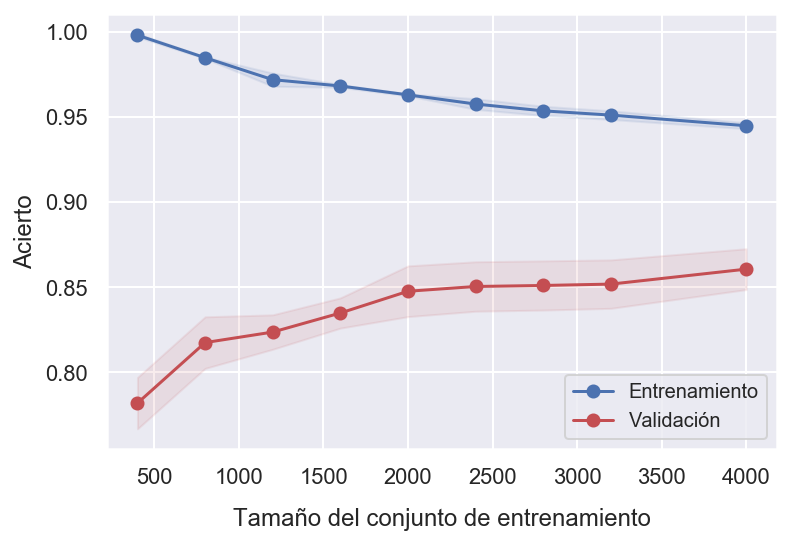

In [29]:
plt.xlabel("Tamaño del conjunto de entrenamiento", labelpad=10)
plt.ylabel("Acierto")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")

plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Validación")
plt.legend(loc=4, fontsize=10)
plt.show()

<a id="section62"></a>
## <font color="#004D7F">6.2. Evaluación  del modelo </font>

El rendimiento real del modelo __ha de ser evaluado con datos no utilizados en el proceso de aprendizaje o validación__. 

La evaluación del rendimiento del modelo anterior, almacenado en `lr_model`, se hará sobre los datos del  _DataFrame_ `df_new_reviews`. Para ello, es necesario someter los nuevos comentarios al mismo proceso de limpieza y preprocesamiento, es decir, eliminación de HTML, elminación de caracteres no alfanuméricos, y conversión en una matriz $tf-idf$. En este último paso, __es necesario utilizar el mismo objeto__ `TfidfVectorizer` creado para el entrenamiento del modelo para producir la matriz de datos `tfidf_test`. Por último, se copiará esa matriz de datos en la variable `X_test` (esto es por claridad en la notación, no haría falta), y se obtendrán los valores del campo `sentiment` de `df_new_reviews`, que se almacenarán en la variable `y_test`.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Preprocesar el conjunto de test y evaluar el rendimiento del modelo sobre nuevos comentarios.

In [30]:
# Los limpia
df_new_reviews['review'] = df_new_reviews['review'].apply(removeHTML)
df_new_reviews['review'] = df_new_reviews['review'].apply(clean)

# Extrae los términos 
tfidf_test = tfidf_vect.transform(df_new_reviews['review'])

# Crea el conjunto de validación
X_test = tfidf_test
y_test = df_new_reviews['sentiment'].values

# Clasifica
print("La tasa de acierto (test) es: ", lr_model.score(X_test,y_test))

La tasa de acierto (test) es:  0.8634



El ejercicio anterior devuelve la tasa de acierto, que indica la probabilidad de clasificar correctamente una revisión. Sin embargo, si se quiere hacer una __estimación global__ de la tasa de comentarios positivos, y asumiento que el error se distribuye independientemente de la clase, es posible obtener algo  más de precisión.


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Obtener la matriz de confusión, reportar la proporción de comentarios positivos real en test, y la proporción de comentarios positivos detectada.

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = lr_model.predict(X_test)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales, 
# y las columnas a las predicciones. 
cm = confusion_matrix(y_test, y_pred)

# Obtiene la proporción real de comentarios positivos, 
# y la proporción etiquetados.
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)
#-------------

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[2110  374]
 [ 309 2207]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.52


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section7"></a>
# <font color="#004D7F"> 7.  Extracción de información del modelo </font>

Además de la función de predicción, el regresión logística permite extraer cierta información con respecto al patrón que subyace en los datos. Así, el valor absoluto de un coeficiente $\theta_t$ refleja la importancia de ese coeficiente en la clasificación, de modo que si $\theta_t$ tiene un __valor absoluto__ alto, eso quiere decir que el término  $t$ es determinante en la clasificación. 

La función `TfidfVectorizer.get_feature_names()` devuelve la lista ordenada de términos en el vocabulario del objeto `TfidfVectorizer`. Por tanto, para obtener las palabras tienen más incidencia en las revisiones, se han de obtener los coeficientes con mayor absoluto, y posteriormente extraer los términos de las posiciones correspondientes a esos coeficientes de la lista.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Obtener e imprimir los 50 términos más relevantes en la clasificación. ¿Tiene sentido la respuesta?

In [32]:
coefficients = lr_model.coef_.ravel()
ord_coefficients = np.argsort(np.abs(coefficients))
best_coefficients = ord_coefficients[-50:]

terms = np.asarray(tfidf_vect.get_feature_names())
relevant_terms = terms[best_coefficients]
print(relevant_terms)

['embarrass' 'unfortun' 'fantast' 'crap' 'would' 'lame' 'mess' 'world'
 'poorli' 'definit' 'money' 'lack' 'today' 'act' 'predict' 'fail' 'fun'
 'amaz' 'ridicul' 'disappoint' 'save' 'instead' 'could' 'perfect' 'beauti'
 'even' 'still' 'script' 'horribl' 'favorit' 'also' 'stupid' 'suppos'
 'plot' 'well' 'wors' 'minut' 'terribl' 'poor' 'bore' 'noth' 'love'
 'excel' 'best' 'enjoy' 'aw' 'wast' 'great' 'worst' 'bad']


<br>
Es posible mostrar las etiquetas más relevantes como una nube de palabras, utilizando el valor absoluto de los coeficientes como peso.

In [34]:
#!pip install wordcloud

     |████████████████████████████████| 365 kB 227 kB/s eta 0:00:01


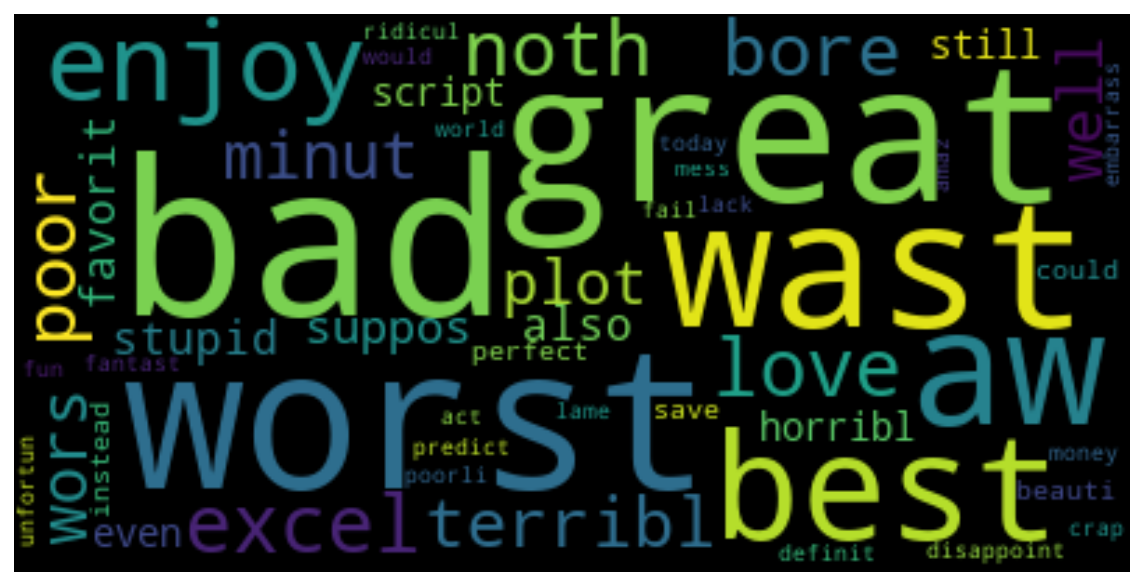

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Crea un diccionario con las palabras y sus scores (como enteros)
scores = (np.abs(coefficients[best_coefficients]*100)).astype(np.int)
tag_scores = dict(zip(relevant_terms,scores))

# Genera la nube de palabras
wordcloud = WordCloud().generate_from_frequencies(tag_scores)

# La muestra
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section8"></a>
# <font color="#004D7F"> 8. Creación de un modelo simple </font>

Es posible pasarle al objeto `TfidfVectorizer` un vocabulario, es decir un diccionario con pares `(término:posicion)`, de modo que solamente considere esos términos en la elaboración de la matriz *tf-idf*, ignorando los demás. 


<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Construir un vocabulario con los términos relevantes obtenidos anteriormente, y crear un objeto `TfidfVectorizer` denominado `tfidf_vect_short` que use dicho vocabulario. Generar después la matriz _tf-idf_ con los datos de las revisiones (las de _IMDB_) denominado `tfidf_reviews_short`, a partir del cual se obtiene la matriz con los datos de entrenamiento, denominada `X_train_short`. Aprender un nuevo modelo, denominado `lr_model_short`,  y evaluar el resultado sobre test. 

In [36]:
# Crea el vocabulario.
new_vocabulary = {}
for position, word in enumerate(relevant_terms):
    new_vocabulary[word] = position

# Crea la nueva matriz de datos.
tfidf_vect_short = TfidfVectorizer(tokenizer=extractTerms, vocabulary=new_vocabulary)
tfidf_reviews_short = tfidf_vect_short.fit_transform(df_reviews['review'])

# Extrae los datos y las clases
X_train_short = tfidf_reviews_short
y_train_short = df_reviews['sentiment'].values

# Entrena el modelo
lr_model_short = LogisticRegression(C=1)
lr_model_short.fit(X_train_short,y_train_short)
print(" Acierto (entrenamiento): ", lr_model_short.score(X_train_short,y_train_short))

# Obtiene el error de test
tfidf_test_short = tfidf_vect_short.transform(df_new_reviews['review'])
X_test_short = tfidf_test_short
y_test_short = df_new_reviews['sentiment'].values
print(" Acierto (test): ", lr_model_short.score(X_test_short,y_test_short))

 Acierto (entrenamiento):  0.8224
 Acierto (test):  0.8096


Vemos que sale un acierto menor, es normal, hemos pasado de podemos ver que tenemos ahora solamente 50 características

In [37]:
tfidf_reviews_short

<5000x50 sparse matrix of type '<class 'numpy.float64'>'
	with 28102 stored elements in Compressed Sparse Row format>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section9"></a>
# <font color="#004D7F"> 9. Unificación todos los pasos mediante un pipeline </font>

En los ejercicios anteriores se ha visto que, para procesar los datos de test, es preciso llevar a cabo la misma secuencia de operaciones que se ha utilizado para preparar los datos de entrenamiento (limpieza y transformación). 
Esta manera de proceder, aunque correcta y didáctica, puede ser una fuente de errores, además de ser poco práctica. 

Es posible llevar a cabo todos los pasos descritos anteriormente mediante un `Pipeline` de `scikit-learn`. Sin embargo, las operaciones de limpieza se han hecho con _Pandas_. Para poderlas incorporar al `Pipeline`, es necesario crear un transformador.  En esta celda, se crea un transformador denominado `Cleaner`, que aplica sucesivamente las funciones `clean` y `removeHTML` a los datos.

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin 

class Cleaner(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):           # No requiere estimar ningún parámetro
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.Series) # Este transformador solo trabaja con Series
        X = X.apply(removeHTML)
        X = X.apply(clean)
        return X

Una vez se dispone del transformador `Cleaner` es posible crear un _Pipeline_ que lleve a cabo los pasos de manera secuencial. En primer lugar, ha de transformar los datos utilizando un objeto de tipo `Cleaner`; después, se ha de construir la matriz _tf-idf_ con un objeto `TfidfVectorizer` que utilizará la función `extractTerms` para obtener los _tokens_, y (por simplificar) el vocabulario reducido obtenido anteriormente `new_vocabulary`; finalmente, se entrenará un modelo de regresión logística con `C=1`.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> </font> Crear el _Pipeline_ descrito anteriormente, al que se denomiará `reviews_pipe`. Entrenarlo con los datos en `df_reviews` y obtener el error sobre `df_new_reviews`.

In [39]:
from sklearn.pipeline import Pipeline

# Crea el objeto TfidfVectorizer utilizando extractTerms para extraer los tokens
tfidf_vect = TfidfVectorizer(tokenizer=extractTerms, vocabulary=new_vocabulary)

# Crea el modelo de regresión logística
lr_model = LogisticRegression(C=1)

# Define el Pipeline
reviews_pipe = Pipeline([
                        ('cleaner', Cleaner()),
                        ('tfidf', tfidf_vect),
                        ('clf', lr_model)])

# Lo entrena
reviews_pipe.fit(df_reviews['review'], df_reviews['sentiment']);

# Imprime la tasa de acierto de entrenamiento
print("Tasa de acierto (entrenamiento): %0.3f" % reviews_pipe.score(df_reviews['review'], df_reviews['sentiment']))
# Imprime la tasa de acierto de entrenamiento
print("Tasa de acierto (test): %0.3f" % reviews_pipe.score(df_new_reviews['review'], df_new_reviews['sentiment']))

Tasa de acierto (entrenamiento): 0.822
Tasa de acierto (test): 0.810


Es posible también utilizar el _Pipeline_ dentro de un objeto `GridSearchCV`. En la siguiente celda se crea un _Pipeline_ similar al anterior, pero se exploran las configuraciones de parámetros, almacenadas en el diccionario `parameters`. Una vez entrenado el modelo, lo almacena en la variable `reviews_pipe` para uso posterior (aunque no haría falta).

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Para esta prueba, no se limitará el vocabulario, ya que uno de los parámetros explorados es `ngram_range`.
</div>

In [40]:
from sklearn.pipeline import Pipeline

# Define el Pipeline
reviews_pipe = Pipeline([
    ('cleaner', Cleaner()),
    ('tfidf', TfidfVectorizer(tokenizer=extractTerms)),
    ('clf', LogisticRegression())
])

# Define los parámetros
parameters = {
    #'tfidf__max_features': [1000, 5000, 10000, 15000, None],
    #'clf__C': np.logspace(-10, 10, 11)
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigramas o bigramas
    'clf__C': [0.1, 1, 10],                     
}

# Crea el objeto GridSearchCV con el Pipeline. 
grid_search = GridSearchCV(reviews_pipe, parameters, cv=4, n_jobs=-1, verbose=1)

# Lo entrena
grid_search.fit(df_reviews['review'], df_reviews['sentiment']);

# Almacena el pipeline entrenado 
reviews_pipe = grid_search.best_estimator_

print("Mejor configuración de parámetros: ")
best_parameters = reviews_pipe.get_params()
for param in sorted(parameters.keys()):
    print("\t%s: %r" % (param, best_parameters[param]))

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.0min finished


Mejor configuración de parámetros: 
	clf__C: 10
	tfidf__max_features: 10000
	tfidf__ngram_range: (1, 2)


Por último, se muestran las tasas de acierto de entrenamiento y test. 

In [41]:
# Imprime la tasa de acierto de entrenamiento
print("Tasa de acierto (entrenamiento): %0.3f" % reviews_pipe.score(df_reviews['review'], df_reviews['sentiment']))
# Imprime la tasa de acierto de entrenamiento
print("Tasa de acierto (test): %0.3f" % reviews_pipe.score(df_new_reviews['review'], df_new_reviews['sentiment']))

Tasa de acierto (entrenamiento): 0.997
Tasa de acierto (test): 0.864


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>